<a href="https://colab.research.google.com/github/Impana1717/customer-segmentation/blob/main/Customer_Segmentation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧠 Customer Segmentation Analysis using K-Means

This Google Colab notebook performs **Customer Segmentation Analysis** using the RFM (Recency, Frequency, Monetary) model and **K-Means clustering**.

---

## ✅ Quick Checklist (What this notebook creates)
1. RFM table construction (auto-detects customer or transaction level data)  
2. Feature engineering and scaling  
3. KMeans clustering with elbow and silhouette methods  
4. PCA visualization of customer clusters  
5. Export `customer_segments.csv` file for download  

---


In [16]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:
# Step 2: Load Data
df = pd.read_csv('/content/ifood_df.csv')


In [18]:
print(df.columns)


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')


In [19]:
# Check for missing values
print(df.isnull().sum())
# Fill or drop missing values as appropriate
df = df.dropna()  # or use df.fillna(value)


Income                  0
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
Customer_Days           0
marital_Divorced        0
marital_Married         0
marital_Single          0
marital_Together        0
marital_Widow           0
education_2n Cycle      0
education_Basic         0
education_Graduation    0
education_Master        0
education_PhD           0
MntTotal                0
MntRegularProds         0
AcceptedCmpO

In [ ]:
# Step 4: RFM Feature Engineering
# Assuming 'Recency' is already in days, 'MntTotal' is monetary, and we need to calculate frequency.
# Let's calculate frequency as the sum of all purchase types.

rfm_df = df.copy()
rfm_df['recencydays'] = rfm_df['Recency']
rfm_df['monetary'] = rfm_df['MntTotal']

# Calculate frequency based on various purchase channels
rfm_df['frequency'] = rfm_df['NumDealsPurchases'] + \
                      rfm_df['NumWebPurchases'] + \
                      rfm_df['NumCatalogPurchases'] + \
                      rfm_df['NumStorePurchases']

# Select only the RFM features and ensure they are numerical
rfm_df = rfm_df[['recencydays', 'frequency', 'monetary']].copy()

print("RFM DataFrame created successfully:")
display(rfm_df.head())

# Step 5: Handle Outliers (using IQR)
# Calculate IQR for RecencyDays, Frequency, and Monetary
Q1 = rfm_df[['recencydays', 'frequency', 'monetary']].quantile(0.25)
Q3 = rfm_df[['recencydays', 'frequency', 'monetary']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
rfm_clean = rfm_df[
    (rfm_df['recencydays'] >= lower_bound['recencydays']) & (rfm_df['recencydays'] <= upper_bound['recencydays']) &
    (rfm_df['frequency'] >= lower_bound['frequency']) & (rfm_df['frequency'] <= upper_bound['frequency']) &
    (rfm_df['monetary'] >= lower_bound['monetary']) & (rfm_df['monetary'] <= upper_bound['monetary'])
].copy()

print(f"Original number of customers: {len(rfm_df)}")
print(f"Number of customers after removing outliers: {len(rfm_clean)}")

display(rfm_clean.head())

RFM DataFrame created successfully:


,recencydays,frequency,monetary
0,58,25,1529
1,38,6,21
2,26,21,734
3,26,8,48
4,94,19,407


Original number of customers: 2205
Number of customers after removing outliers: 2201


,recencydays,frequency,monetary
0,58,25,1529
1,38,6,21
2,26,21,734
3,26,8,48
4,94,19,407


In [ ]:
# Step 6: Feature Scaling
# Scale the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clean[['recencydays', 'frequency', 'monetary']])

# Convert scaled data back to a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['recencydays_scaled', 'frequency_scaled', 'monetary_scaled'])

display(rfm_scaled_df.head())

,recencydays_scaled,frequency_scaled,monetary_scaled
0,0.310100,1.335129,1.695968
1,-0.380894,-1.168066,-0.942453
2,-0.795490,0.808141,0.305023
3,-0.795490,-0.904572,-0.895214
4,1.553888,0.544646,-0.267101


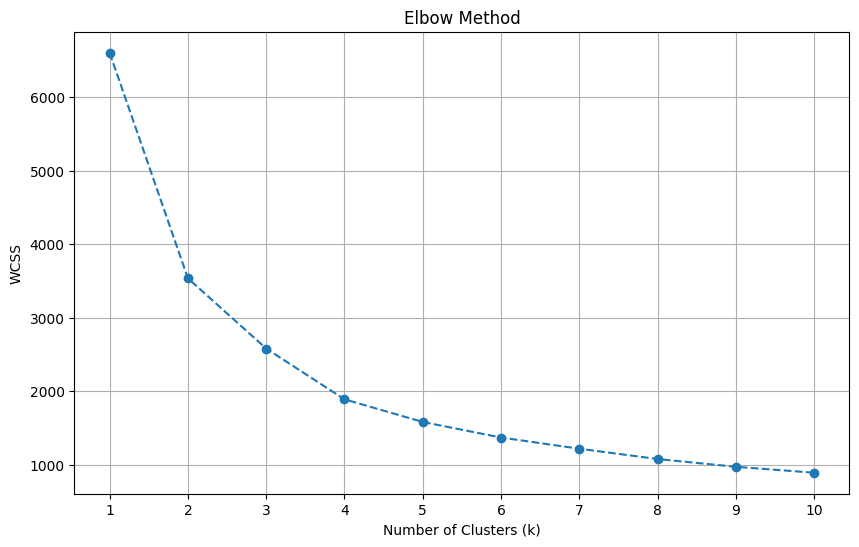

In [ ]:
# Step 7: Determine Optimal Clusters (Elbow Method)
wcss = []
# Try different numbers of clusters (e.g., from 1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10) # Set n_init explicitly
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [ ]:
# Step 8: Apply K-Means Clustering
# Based on the Elbow Method, let's choose a suitable number of clusters (e.g., 4 or 5)
# Let's choose 4 clusters for now.
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # Set n_init explicitly
rfm_clean['Cluster'] = kmeans.fit_predict(rfm_scaled)

display(rfm_clean.head())

,recencydays,frequency,monetary,Cluster
0,58,25,1529,2
1,38,6,21,1
2,26,21,734,0
3,26,8,48,1
4,94,19,407,2


In [ ]:
# Step 9: Analyze Cluster Characteristics
# Group by cluster and calculate the mean of the RFM values
cluster_profile = rfm_clean.groupby('Cluster')[['recencydays', 'frequency', 'monetary']].mean().reset_index()

# Rename columns for better readability
cluster_profile.rename(columns={
    'recencydays': 'AvgRecencyDays',
    'frequency': 'AvgFrequency',
    'monetary': 'AvgMonetary'
}, inplace=True)

display(cluster_profile)

,Cluster,AvgRecencyDays,AvgFrequency,AvgMonetary
0,0,22.459794,21.756701,1036.336082
1,1,24.462185,8.662185,109.557983
2,2,72.519266,21.577982,1091.366972
3,3,74.534722,9.121528,120.161458


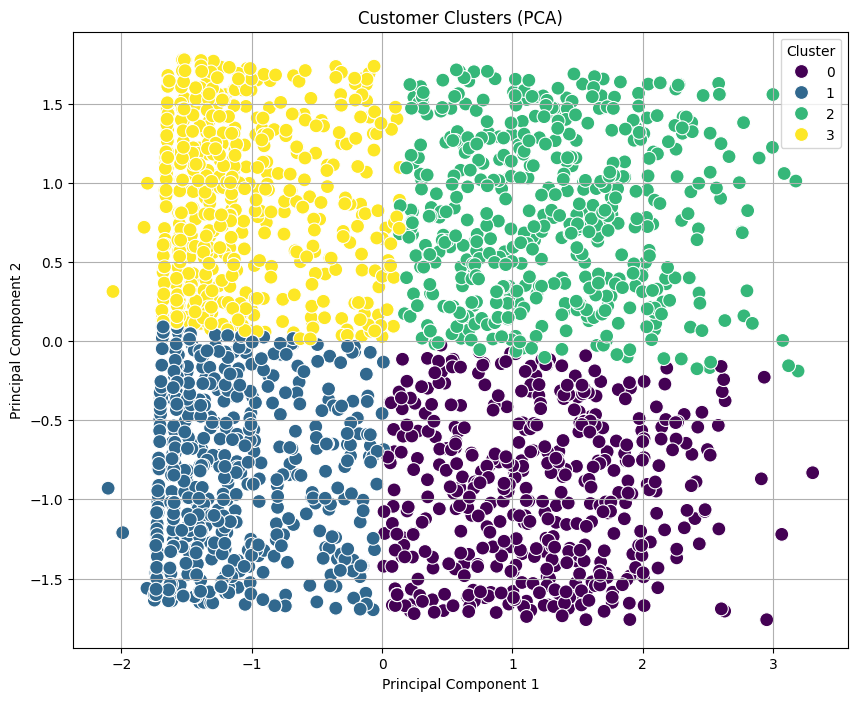

In [ ]:
# Step 10: Visualize Clusters using PCA
# Apply PCA to the scaled RFM data
pca = PCA(n_components=2) # Reduce to 2 components for visualization
rfm_pca = pca.fit_transform(rfm_scaled)

# Add the PCA components and cluster labels to a new DataFrame for plotting
rfm_pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'])
rfm_pca_df['Cluster'] = rfm_clean['Cluster'].values # Get cluster labels from the cleaned data

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm_pca_df, palette='viridis', s=100)
plt.title('Customer Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
# Step 11: Export Results
# Merge the cluster labels back to the original dataframe (or the cleaned one)
# Ensure the 'customerid' is the index or a column in both dataframes for merging
rfm_clean_with_clusters = rfm_clean.copy()

# Merge with the original dataframe if needed, here we are adding to the cleaned one
# If you need to merge with the original df, make sure 'customerid' is the merge key
# final_df = df.merge(rfm_clean_with_clusters[['customerid', 'Cluster']], on='customerid', how='left')

# For now, let's save the cleaned RFM data with clusters
rfm_clean_with_clusters.to_csv('customer_segments.csv', index=False)

print("Customer segments exported to 'customer_segments.csv'")

Customer segments exported to 'customer_segments.csv'


In [ ]:
# This is a shell command using the ! prefix
# It moves the file to a different location within the Colab environment
!mv customer_segments.csv /content/

# To download to your local machine, please use the file browser on the left.

mv: 'customer_segments.csv' and '/content/customer_segments.csv' are the same file
